In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(mnist.train.images.shape)
print(mnist.test.images.shape)
print(mnist.validation.images.shape)
mnist.train.labels.shape
input_reshape_1 = tf.reshape(mnist.train.images, [-1, 28, 28, 1])
input_reshape_2 = tf.reshape(mnist.train.labels, [-1, 10])
input_reshape_1.shape
input_reshape_2.shape

(55000, 784)
(10000, 784)
(5000, 784)


TensorShape([Dimension(55000), Dimension(10)])

# Problem 2: Set up a 2-layer CNN (no pooling, no dropout) using Tensorflow 

a) Specify the network without stride and 3x3 or 5x5 filter sizes. You can choose the number
of filters in each layer and the number of hidden units of the first fully connected layer.


First convolutional layer: 32 filters with filter size 5x5

Second convolutional layer: 64 filters with filter size 5x5

Fully connected layer: 1024 hidden units

b) Calculate the receptive field of your 2-layer CNN for a 28x28 MNIST image.

After two convolutional layers, the receptive field size is 9, stride size 1.

In [4]:
tf.reset_default_graph()

In [5]:
def cnn_model_no_pooling_no_dropout(iterations=1000):
    
    tf.reset_default_graph() 
    
    # placeholder variable for input/output
    X = tf.placeholder(tf.float32, [None, 784], name="X")
    Y = tf.placeholder(tf.float32, [None, 10], name="Y")

    
    # define inputs
    Y_ = tf.reshape(X, [-1, 28, 28, 1])

    
    # define convolution 1
    Y_ = tf.layers.conv2d(
      inputs=Y_,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    
    # define convolution 2
    Y_ = tf.layers.conv2d(
      inputs=Y_,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
     
    
    # flatten
    Y_ = tf.contrib.layers.flatten(Y_)
    
    # fully connected layer 1
    Y_ = tf.layers.dense(inputs=Y_, units=1024, activation=tf.nn.relu)

    
    # output layer
    output = tf.layers.dense(inputs=Y_, units=10, activation=None)
    
    #loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=Y))
    
    #back
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    model_variables = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_variables, print_info=True)
    
    loss = []
    validation_acc = []
    
    init = [tf.global_variables_initializer(),tf.local_variables_initializer()]
    with tf.Session() as sess:
        sess.run(init)
        print('start training...')
        for i in range(iterations):
            minibatch = mnist.train.next_batch(64)
            (minibatch_X, minibatch_Y) = minibatch
            # print(minibatch_X.shape,minibatch_Y.shape)
            _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

            # report every 100 iterations
            if i % 50 == 0:
                loss.append(minibatch_cost)
                #validation
                
                validation_accuracy = 0
                for v in range(10):
                    batch = mnist.validation.next_batch(50)
                    validation_accuracy += (1/10) * accuracy.eval(feed_dict={X: batch[0], Y: batch[1]})
                
                validation_acc.append(validation_accuracy)
                print('{} iterations: training loss {}, validation accuracy {}'\
                      .format(i,minibatch_cost,validation_accuracy))
                
        train_acc = 0
        test_acc = 0
        for v in range(100):
            batch_train = mnist.train.next_batch(550)
            batch_test = mnist.test.next_batch(100)
            train_acc += (1/100) * accuracy.eval(feed_dict={X: batch_train[0], Y: batch_train[1]})
            test_acc += (1/100) * accuracy.eval(feed_dict={X: batch_test[0], Y: batch_test[1]})
            
        print("Train Accuracy:", train_acc)
        print("Test Accuracy:", test_acc)
        
        #params = sess.run(params)
        return validation_acc, loss

In [6]:
v_acc1, loss1 = cnn_model_no_pooling_no_dropout()

---------
Variables: name (type shape) [size]
---------
conv2d/kernel:0 (float32_ref 5x5x1x32) [800, bytes: 3200]
conv2d/bias:0 (float32_ref 32) [32, bytes: 128]
conv2d_1/kernel:0 (float32_ref 5x5x32x64) [51200, bytes: 204800]
conv2d_1/bias:0 (float32_ref 64) [64, bytes: 256]
dense/kernel:0 (float32_ref 50176x1024) [51380224, bytes: 205520896]
dense/bias:0 (float32_ref 1024) [1024, bytes: 4096]
dense_1/kernel:0 (float32_ref 1024x10) [10240, bytes: 40960]
dense_1/bias:0 (float32_ref 10) [10, bytes: 40]
Total size of variables: 51443594
Total bytes of variables: 205774376
start training...
0 iterations: training loss 2.3094258308410645, validation accuracy 0.11600000113248829
50 iterations: training loss 0.21653497219085693, validation accuracy 0.9380000054836275
100 iterations: training loss 0.2253880798816681, validation accuracy 0.962000000476837
150 iterations: training loss 0.2292708158493042, validation accuracy 0.9659999907016754
200 iterations: training loss 0.05778928101062775, 

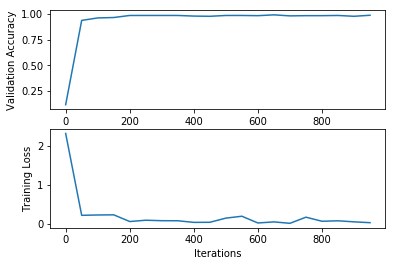

In [7]:
x = range(0,1000,50)
# compare validation accuracy for different step size
plt.subplot(2,1,1)
plt.plot(x,v_acc1)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.subplot(2,1,2)
plt.plot(x,loss1)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

# Problem 3: Adding pooling and dropout to a 2-layer CNN with TensorFlow 

# (a) Set up a 2-layer CNN (w/ pooling, no dropout) using Tensorflow

In [8]:
def cnn_model_pooling_no_dropout(iterations=1000):
    
    tf.reset_default_graph() 
    
    # placeholder variable for input/output
    X = tf.placeholder(tf.float32, [None, 784], name="X")
    Y = tf.placeholder(tf.float32, [None, 10], name="Y")

    
    # define inputs
    Y_ = tf.reshape(X, [-1, 28, 28, 1])

    
    # define convolution 1
    Y_ = tf.layers.conv2d(
      inputs=Y_,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    # define max-poolling 1
    Y_ = tf.layers.max_pooling2d(inputs=Y_, pool_size=[2, 2], strides=2)
    
    
    # define convolution 2
    Y_ = tf.layers.conv2d(
      inputs=Y_,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
     
    
    #define max-pooling 2
    Y_ = tf.layers.max_pooling2d(inputs=Y_, pool_size=[2, 2], strides=2)
    
    # flatten
    Y_ = tf.contrib.layers.flatten(Y_)
    
    # fully connected layer 1
    Y_ = tf.layers.dense(inputs=Y_, units=1024, activation=tf.nn.relu)
    
    # output layer
    output = tf.layers.dense(inputs=Y_, units=10, activation=None)
    
    #loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=Y))
    
    #back
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    model_variables = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_variables, print_info=True)
    
    loss = []
    validation_acc = []
    
    init = [tf.global_variables_initializer(),tf.local_variables_initializer()]
    with tf.Session() as sess:
        sess.run(init)
        print('start training...')
        for i in range(iterations):
            minibatch = mnist.train.next_batch(64)
            (minibatch_X, minibatch_Y) = minibatch
            # print(minibatch_X.shape,minibatch_Y.shape)
            _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

            # report every 100 iterations
            if i % 50 == 0:
                loss.append(minibatch_cost)
                #validation
                
                validation_accuracy = 0
                for v in range(10):
                    batch = mnist.validation.next_batch(50)
                    validation_accuracy += (1/10) * accuracy.eval(feed_dict={X: batch[0], Y: batch[1]})
                
                validation_acc.append(validation_accuracy)
                print('{} iterations: training loss {}, validation accuracy {}'\
                      .format(i,minibatch_cost,validation_accuracy))
                
        train_acc = 0
        test_acc = 0
        for v in range(100):
            batch_train = mnist.train.next_batch(550)
            batch_test = mnist.test.next_batch(100)
            train_acc += (1/100) * accuracy.eval(feed_dict={X: batch_train[0], Y: batch_train[1]})
            test_acc += (1/100) * accuracy.eval(feed_dict={X: batch_test[0], Y: batch_test[1]})
            
        print("Train Accuracy:", train_acc)
        print("Test Accuracy:", test_acc)
        
        #params = sess.run(params)
        return validation_acc, loss

In [9]:
v_acc2, loss2 = cnn_model_pooling_no_dropout()

---------
Variables: name (type shape) [size]
---------
conv2d/kernel:0 (float32_ref 5x5x1x32) [800, bytes: 3200]
conv2d/bias:0 (float32_ref 32) [32, bytes: 128]
conv2d_1/kernel:0 (float32_ref 5x5x32x64) [51200, bytes: 204800]
conv2d_1/bias:0 (float32_ref 64) [64, bytes: 256]
dense/kernel:0 (float32_ref 3136x1024) [3211264, bytes: 12845056]
dense/bias:0 (float32_ref 1024) [1024, bytes: 4096]
dense_1/kernel:0 (float32_ref 1024x10) [10240, bytes: 40960]
dense_1/bias:0 (float32_ref 10) [10, bytes: 40]
Total size of variables: 3274634
Total bytes of variables: 13098536
start training...
0 iterations: training loss 2.3045730590820312, validation accuracy 0.09199999906122686
50 iterations: training loss 0.16075460612773895, validation accuracy 0.9639999926090239
100 iterations: training loss 0.03353551775217056, validation accuracy 0.9699999988079069
150 iterations: training loss 0.056963346898555756, validation accuracy 0.978000009059906
200 iterations: training loss 0.1101921945810318, val

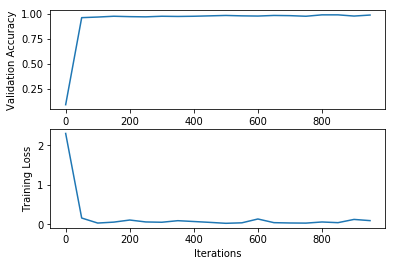

In [10]:
x = range(0,1000,50)
# compare validation accuracy for different step size
plt.subplot(2,1,1)
plt.plot(x,v_acc2)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.subplot(2,1,2)
plt.plot(x,loss2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

# (b) Set up a 2-layer CNN (w/ pooling, w/ dropout) using Tensorflow

In [11]:
def cnn_model_pooling_dropout(iterations=1000):
    
    tf.reset_default_graph() 
    
    # placeholder variable for input/output
    X = tf.placeholder(tf.float32, [None, 784], name="X")
    Y = tf.placeholder(tf.float32, [None, 10], name="Y")

    
    # define inputs
    Y_ = tf.reshape(X, [-1, 28, 28, 1])

    
    # define convolution 1
    Y_ = tf.layers.conv2d(
      inputs=Y_,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    #define max-poolling 1
    Y_ = tf.layers.max_pooling2d(inputs=Y_, pool_size=[2, 2], strides=2)
    
    
    # define convolution 2
    Y_ = tf.layers.conv2d(
      inputs=Y_,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
     
    
    # define max-pooling 2
    Y_ = tf.layers.max_pooling2d(inputs=Y_, pool_size=[2, 2], strides=2)
    
    # flatten
    Y_ = tf.contrib.layers.flatten(Y_)
    
    # fully connected layer 1
    Y_ = tf.layers.dense(inputs=Y_, units=1024, activation=tf.nn.relu)
    
    # apply dropout
    Y_ = tf.layers.dropout(inputs=Y_, rate=0.5)
    
    # output layer
    output = tf.layers.dense(inputs=Y_, units=10, activation=None)
    
    #loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=Y))
    
    #back
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    model_variables = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_variables, print_info=True)
    
    loss = []
    validation_acc = []
    
    init = [tf.global_variables_initializer(),tf.local_variables_initializer()]
    with tf.Session() as sess:
        sess.run(init)
        print('start training...')
        for i in range(iterations):
            minibatch = mnist.train.next_batch(64)
            (minibatch_X, minibatch_Y) = minibatch
            # print(minibatch_X.shape,minibatch_Y.shape)
            _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

            # report every 100 iterations
            if i % 50 == 0:
                loss.append(minibatch_cost)
                #validation
                
                validation_accuracy = 0
                for v in range(10):
                    batch = mnist.validation.next_batch(50)
                    validation_accuracy += (1/10) * accuracy.eval(feed_dict={X: batch[0], Y: batch[1]})
                
                validation_acc.append(validation_accuracy)
                print('{} iterations: training loss {}, validation accuracy {}'\
                      .format(i,minibatch_cost,validation_accuracy))
                
        train_acc = 0
        test_acc = 0
        for v in range(100):
            batch_train = mnist.train.next_batch(550)
            batch_test = mnist.test.next_batch(100)
            train_acc += (1/100) * accuracy.eval(feed_dict={X: batch_train[0], Y: batch_train[1]})
            test_acc += (1/100) * accuracy.eval(feed_dict={X: batch_test[0], Y: batch_test[1]})
            
        print("Train Accuracy:", train_acc)
        print("Test Accuracy:", test_acc)
        
        #params = sess.run(params)
        return validation_acc, loss

In [12]:
v_acc3, loss3 = cnn_model_pooling_dropout()

---------
Variables: name (type shape) [size]
---------
conv2d/kernel:0 (float32_ref 5x5x1x32) [800, bytes: 3200]
conv2d/bias:0 (float32_ref 32) [32, bytes: 128]
conv2d_1/kernel:0 (float32_ref 5x5x32x64) [51200, bytes: 204800]
conv2d_1/bias:0 (float32_ref 64) [64, bytes: 256]
dense/kernel:0 (float32_ref 3136x1024) [3211264, bytes: 12845056]
dense/bias:0 (float32_ref 1024) [1024, bytes: 4096]
dense_1/kernel:0 (float32_ref 1024x10) [10240, bytes: 40960]
dense_1/bias:0 (float32_ref 10) [10, bytes: 40]
Total size of variables: 3274634
Total bytes of variables: 13098536
start training...
0 iterations: training loss 2.3151631355285645, validation accuracy 0.2060000032186508
50 iterations: training loss 0.18690328299999237, validation accuracy 0.9439999878406526
100 iterations: training loss 0.16149966418743134, validation accuracy 0.9699999988079072
150 iterations: training loss 0.18471196293830872, validation accuracy 0.9840000092983247
200 iterations: training loss 0.10633204877376556, val

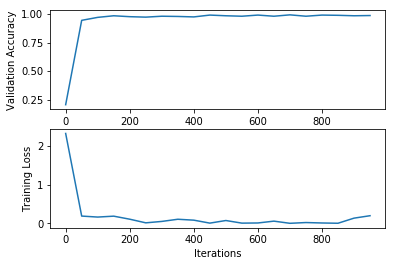

In [13]:
x = range(0,1000,50)
# compare validation accuracy for different step size
plt.subplot(2,1,1)
plt.plot(x,v_acc3)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.subplot(2,1,2)
plt.plot(x,loss3)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

In [15]:
plt.plot(x,v_acc1,label='no pooling, no dropout',color='r')
plt.plot(x,v_acc2,label='pooling, no dropout',color='b')
plt.plot(x,v_acc3,label='pooling, dropout',color='y')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('Validation Accuracy')

## Zooming on early iterations

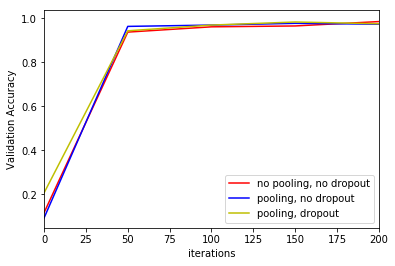

In [16]:
plt.plot(x,v_acc1,label='no pooling, no dropout',color='r')
plt.plot(x,v_acc2,label='pooling, no dropout',color='b')
plt.plot(x,v_acc3,label='pooling, dropout',color='y')
plt.xlim([0,200])
plt.legend()
plt.xlabel('iterations')
plt.ylabel('Validation Accuracy')

## Zooming on validation accuracy

In [17]:
plt.plot(x,v_acc1,label='no pooling, no dropout',color='r')
plt.plot(x,v_acc2,label='pooling, no dropout',color='b')
plt.plot(x,v_acc3,label='pooling, dropout',color='y')
plt.ylim([0.8,1])
plt.legend()
plt.xlabel('iterations')
plt.ylabel('Validation Accuracy')

# Problem 4: Performance comparison

(a) What is the validation accuracy of the CNN with and without pooling?

After 1000 iterations of training,

without pooling, the validation accuracy is 98.8%

with pooling, the validation accuracy is 99.0%

b) Did you observe any performance improvements after adding dropout?

No significant improvements.

c) How does the CNN model compare, in terms of performance, to the multi-class logistic
regression and multi-class MLP from HW2?

Based on the performance numbers reported from Homework1 and Homework2, Multi-class Logistic Regression has the best accuracy about 92%; Multi-class MLP (with two hidden layers) has the best accuracy about 96%.

The CNN model defined in this homework has the accuracy about 98%-99%. CNN model significantly improves the prediction performance compared to both single layer Logistic Regression or multi layer Logistic Regression.

d) How does the number of trainable parameters in the CNN models compare to that of the
multi-class logistic regression and multi-class MLP from HW2?

As reported after each model definition:

2-layer CNN without pooling, there are 51,443,594 trainable parameters in total

2-layer CNN with pooling, there are 3,274,634 trainable parameters in total.

Compared with multi-class logistic regression and multi-class MLP from HW2, CNN model has a much larger size of parameters to train, which makes the model training much slower.